In [1]:
%matplotlib inline
import os
import re
import io

import matplotlib
import numpy as np
import pandas as pd
import xarray as xr

import climatools.html.html as climahtml
import climatools.scripts.g1_threshold as scripts

import IPython.display as display

import imp
imp.reload(scripts)

/chia_cluster/home/jackyu/anaconda3/lib/python3.6/site-packages/matplotlib/__init__.py:1405: UserWarning: 
This call to matplotlib.use() has no effect because the backend has already
been chosen; matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

  warnings.warn(_use_error_msg)


<module 'climatools.scripts.g1_threshold' from '/chia_cluster/home/jackyu/climatools/climatools/scripts/g1_threshold.py'>

In [2]:
%run params.py

In [3]:
# for printing some input parameters

def innames():
    return ['vstar', 'nband', 'nv', 'dv',
            'flgh2o',
            'tsfc',
            'pressure_reference_1',
            'temperature_reference_1', 
            'pressure_reference_2', 
            'temperature_reference_2',
            'ighigh', 
            'ng', 
            'nref',
            'p_refs',
            't_refs',
            'ng_refs',
            'absth',
            'wgt',
            'option_wgt_flux',
            'option_wgt_k',
            'option_klin',
            'w_diffuse',
            'fac_meank',
            'klin']



def pattern_assign(name):
    return ''' 
    parameter .* :: \s* &? \s* ({} \s* = .* \n)
    '''.format(name)

def pattern_data(name):
    return '''
    (data [^/{name}]+ {name}[^,] [^/{name}]+ / [^/]+ /)
    '''.format(name=name)

def pattern_atmpro():
    return '''
    (atmosphere_profiles/.*75_r8.pro)
    '''
    

def get_input_params(code, names):
    results = []
    for name in names:
        regex = re.compile(pattern_assign(name), re.VERBOSE)
        results.extend(regex.findall(code))
        
        regex = re.compile(pattern_data(name), re.VERBOSE)
        results.extend(regex.findall(code))
        
    regex = re.compile(pattern_atmpro(), re.VERBOSE)
    results.extend(regex.findall(code))
        
    results = [result.replace('_r8', '') for result in results]
    return results


In [4]:
analysis = scripts.Analysis()

In [5]:
crd = analysis.model('crd')
crd.type_model = 'crd'
crd.rundir = DIR_CRD
crd.fpath_flux = 'output_fluxg.dat'
crd.fpath_coolr = 'output_coolrg.dat'
crd.linestyle = '-'
crd.load_data()

In [6]:
iggs = [1, 10]
linestyles = ['--', ':']

df_wfluxg = pd.read_csv(os.path.join(crd.rundir, 'output_wfluxg.dat'), 
                 sep=r'\s+')

df_wcoolrg = pd.read_csv(os.path.join(crd.rundir, 'output_wcoolrg.dat'), 
                 sep=r'\s+')

for igg, linestyle in zip(iggs, linestyles):

    flux_igg = df_wfluxg[df_wfluxg['igg'] == igg].drop('igg', axis=1)
    s_flux = io.StringIO(flux_igg.to_csv(sep=' '))

    coolr_igg = df_wcoolrg[df_wcoolrg['igg'] == igg].drop('igg', axis=1)
    s_coolr = io.StringIO(coolr_igg.to_csv(sep=' '))


    crdx_igg = analysis.model('wgt_igg{}'.format(igg))
    crdx_igg.type_model = 'crd'
    crdx_igg.rundir = DIR_XCRD
    crdx_igg.fpath_flux = s_flux
    crdx_igg.fpath_coolr = s_coolr
    crdx_igg.linestyle = linestyle
    crdx_igg.load_data()

In [7]:
fig = analysis.fig_fluxcoolr('fig1', vartypes=['cooling rate'])
fig.ggroups = list(crd.data['dgdgs'].coords['g'].values) #list(range(1, 8 + 1))
fig.vars_plot['flux'] = ['flug', 'fnetg']
fig.vars_plot['cooling rate'] = ['coolrg']
fig.colors['flug'] = 'darkred'
fig.colors['fnetg'] = 'lightcoral'
fig.colors['coolrg'] = 'blue'
fig.varlims_from_indexrange['linear'] = (50, 1050)
fig.varlims_from_indexrange['log'] = (1e-2, 200)

fig.set_pressure_displayrange(low=1e-2)

In [8]:
table_fluxg = analysis.table('table_fluxg')
table_fluxg.sumg = False
table_fluxg.vartype = 'flux'
table_fluxg.at_pressures = crd.data['flux']\
                             .coords['pressure']\
                             .isel(pressure=[0, -1])

table_coolrg = analysis.table('table_coolrg')
table_coolrg.vartype = 'cooling rate'
table_coolrg.sumg = False
table_coolrg.at_pressures = crd.data['cooling rate']\
                               .coords['pressure']\
                               .isel(pressure=[0, -1])


In [9]:
table_flux = analysis.table('table_flux')
table_flux.sumg = True
table_flux.vartype = 'flux'
table_flux.at_pressures = crd.data['flux']\
                             .coords['pressure']\
                             .isel(pressure=[0, -1])

table_coolr = analysis.table('table_coolr')
table_coolr.vartype = 'cooling rate'
table_coolr.sumg = True
table_coolr.at_pressures = crd.data['cooling rate']\
                              .coords['pressure']\
                              .isel(pressure=[0, -1])

In [10]:
table_dgdgs = analysis.table('dgdgs')
table_dgdgs.vartype = 'dgdgs'
table_dgdgs.sumg = False

In [11]:
with open(os.path.join(crd.rundir, 'lblnew.f'), 
          mode='r', encoding='utf-8') as f:
    c = f.read()

print('\n\n'.join(get_input_params(c, innames())))

vstar = 1900

nband = 1100

nv = 200

dv = 0.005

tsfc =300

ng =6

nref =2

p_refs = (/ 1 , 50 /) 

t_refs = (/ 250 , 250 /) 

ng_refs = (/ 3 , 3 /) 

data wgt
     &     /0.7 , 0.7 , 0.7 , 0.7,
     &     0.7 , 0.8/

option_wgt_flux =2

option_wgt_k =1

option_klin =1

data w_diffuse
     &     /1.66 , 1.66 , 1.66 , 1.66,
     &     1.66 , 1.8/

klin =6.5e-24

atmosphere_profiles/trp75.pro


In [12]:
fig.display_hrefanchor()

In [13]:
table_fluxg.display_hrefanchor()
table_coolrg.display_hrefanchor()

table_flux.display_hrefanchor()
table_coolr.display_hrefanchor()

In [14]:
table_dgdgs.display_hrefanchor()

In [15]:
s_abscom = 'Overall absth'
display.HTML(climahtml.getHTML_hrefanchor(s_abscom))

In [16]:
s_ggroup_summary = 'g-group summary'
display.HTML(climahtml.getHTML_hrefanchor(s_ggroup_summary))

In [17]:
#for g in range(1, 20 + 1):
#    s = 'Table: cooling rate. g-group {}'.format(g)
#    html = climahtml.getHTML_hrefanchor(s)
#    display.display(display.HTML(html))

# Figure: cooling rate g-group 1

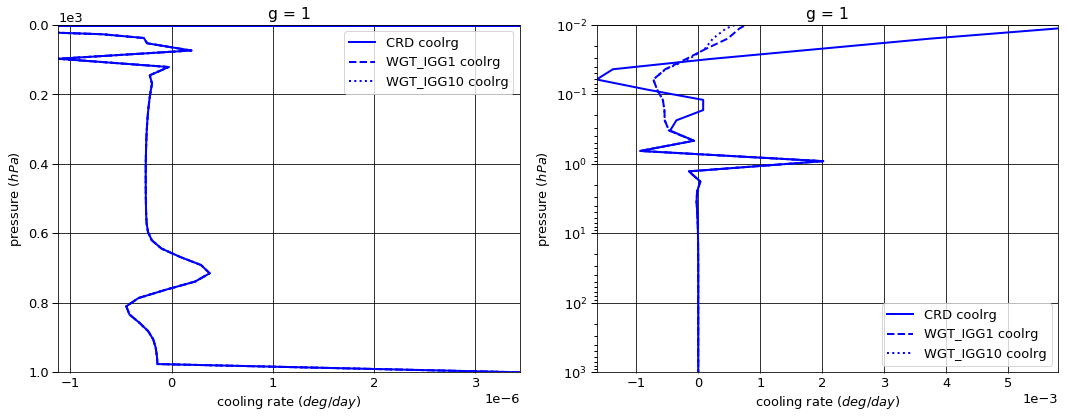

# Figure: cooling rate g-group 2

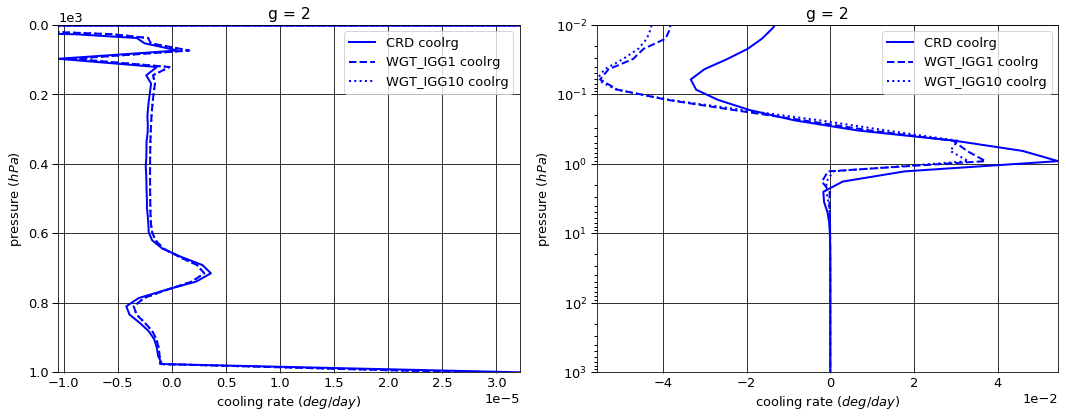

# Figure: cooling rate g-group 3

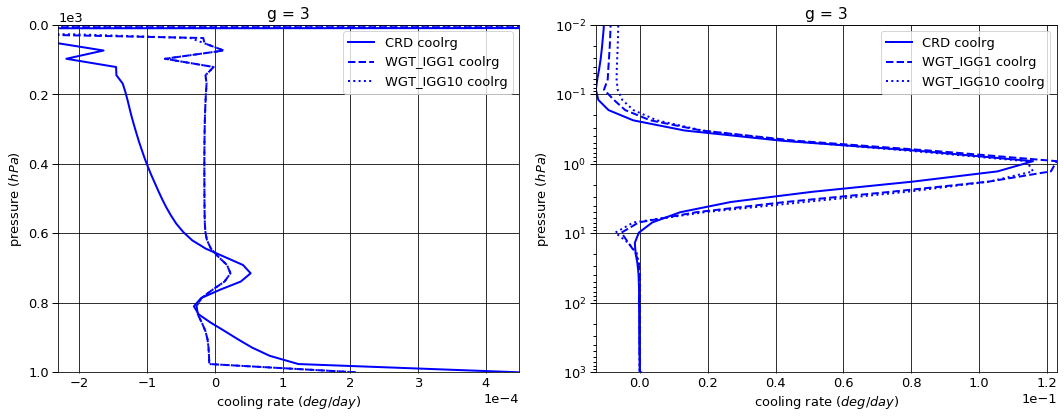

# Figure: cooling rate g-group 4

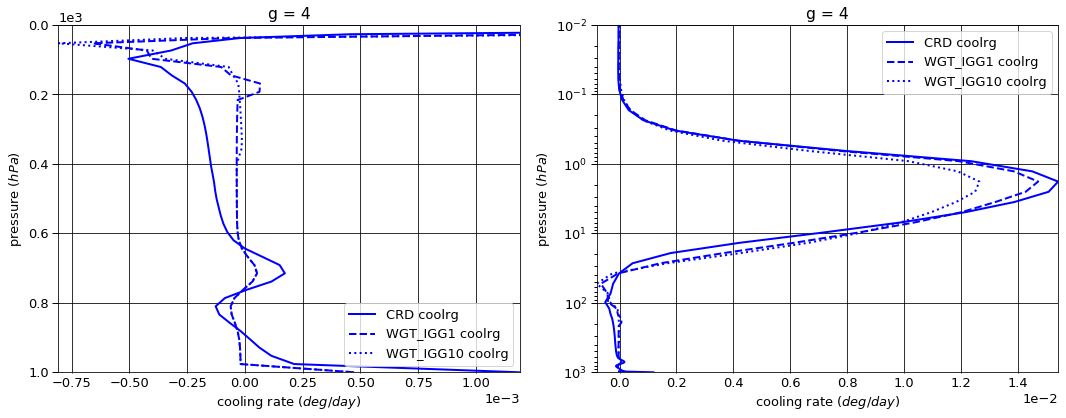

# Figure: cooling rate g-group 5

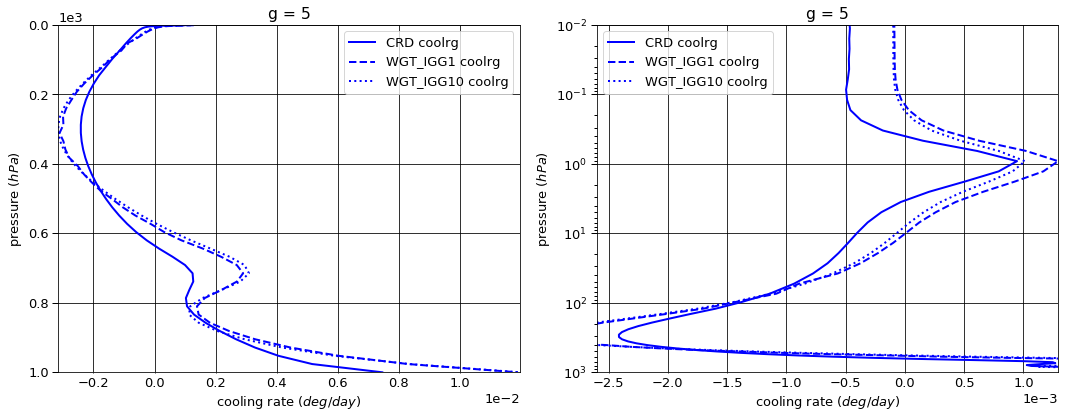

# Figure: cooling rate g-group 6

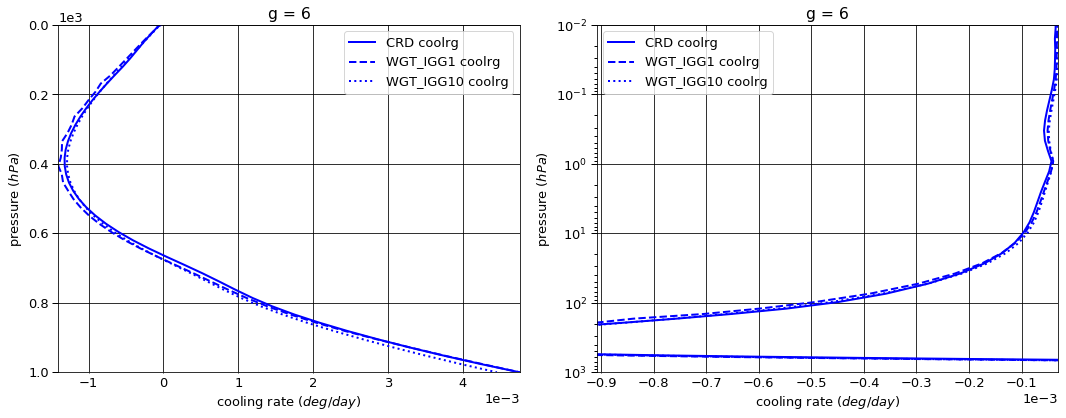

# Figure: cooling rate g-group total

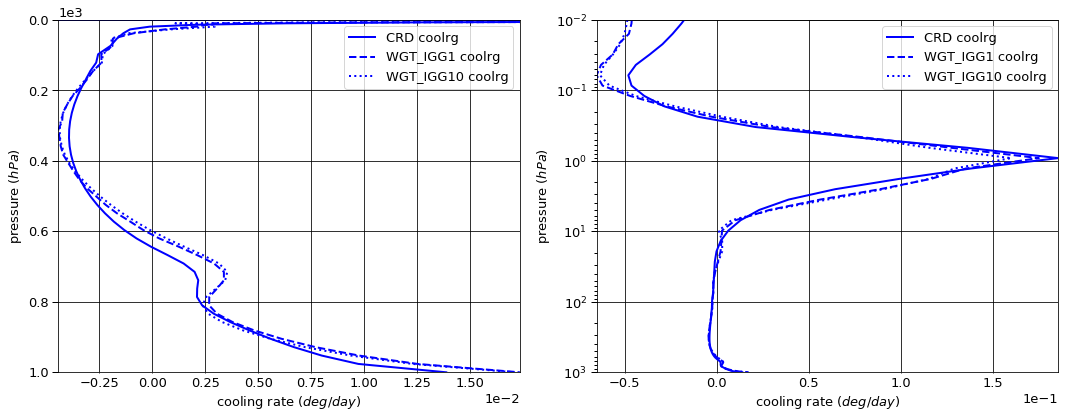

In [18]:
matplotlib.rcParams.update({'font.size': 13,
                            'grid.color': 'black',
                            'axes.facecolor': 'white',
                            'axes.edgecolor': 'black',
                            'ytick.direction': 'out',
                            'ytick.major.size': 6, 'ytick.major.width': 1,
                            'ytick.minor.size': 3, 'ytick.minor.width': 1,
                            'xtick.direction': 'out',
                            'xtick.major.size': 6, 'xtick.major.size': 1,
                            'xtick.minor.size': 3, 'xtick.minor.size': 1}) 

fig.plot(analysis)


In [19]:
table_fluxg.display_withdiff(analysis, benchmark='crd')
table_coolrg.display_withdiff(analysis, benchmark='crd')
table_flux.display_withdiff(analysis, benchmark='crd')
table_coolr.display_withdiff(analysis, benchmark='crd')

# Table: flux. g-groups 


CRD


flug      fldg     fnetg
g pressure level                              
1 0.0      1     -0.000039  0.000000 -0.000039
  1013.0   76    -0.003955  0.003945 -0.000010
2 0.0      1     -0.003562  0.000000 -0.003562
  1013.0   76    -0.031409  0.031315 -0.000094
3 0.0      1     -0.028299  0.000000 -0.028299
  1013.0   76    -0.242445  0.236008 -0.006437
4 0.0      1     -0.017914  0.000000 -0.017914
  1013.0   76    -0.554196  0.546091 -0.008105
5 0.0      1     -0.381797  0.000000 -0.381797
  1013.0   76    -0.920128  0.512865 -0.407263
6 0.0      1     -6.279450  0.000000 -6.279450
  1013.0   76    -6.433006  0.172602 -6.260404


WGT_IGG1


flug      fldg     fnetg
g pressure level                              
1 0.0      1     -0.000034  0.000000 -0.000034
  1013.0   76    -0.003955  0.003945 -0.000010
2 0.0      1     -0.001556  0.000000 -0.001556
  1013.0   76    -0.031409  0.031331 -0.000078
3 0.0      1     -0.032564  0.000000 -0.032564
  1013.0   76    -0.242445  0.241848 -0.000598
4 0.0      1     -0.018510  0.000000 -0.018510
  1013.0   76    -0.554196  0.552833 -0.001362
5 0.0      1     -0.154451  0.000000 -0.154451
  1013.0   76    -0.920128  0.796234 -0.123894
6 0.0      1     -6.283728  0.000000 -6.283728
  1013.0   76    -6.433006  0.161132 -6.271874


WGT_IGG10


flug      fldg     fnetg
g pressure level                              
1 0.0      1     -0.000034  0.000000 -0.000034
  1013.0   76    -0.003955  0.003945 -0.000010
2 0.0      1     -0.001438  0.000000 -0.001438
  1013.0   76    -0.031409  0.031331 -0.000078
3 0.0      1     -0.032746  0.000000 -0.032746
  1013.0   76    -0.242445  0.241848 -0.000598
4 0.0      1     -0.018056  0.000000 -0.018056
  1013.0   76    -0.554196  0.552833 -0.001362
5 0.0      1     -0.140457  0.000000 -0.140457
  1013.0   76    -0.920128  0.808681 -0.111447
6 0.0      1     -6.295071  0.000000 -6.295071
  1013.0   76    -6.433006  0.149022 -6.283984


WGT_IGG1 - CRD


flug      fldg     fnetg
g pressure level                              
1 0.0      1      0.000005  0.000000  0.000005
  1013.0   76     0.000000  0.000000  0.000000
2 0.0      1      0.002006  0.000000  0.002006
  1013.0   76     0.000000  0.000016  0.000016
3 0.0      1     -0.004265  0.000000 -0.004265
  1013.0   76     0.000000  0.005840  0.005840
4 0.0      1     -0.000596  0.000000 -0.000596
  1013.0   76     0.000000  0.006742  0.006742
5 0.0      1      0.227346  0.000000  0.227346
  1013.0   76     0.000000  0.283369  0.283369
6 0.0      1     -0.004278  0.000000 -0.004278
  1013.0   76     0.000000 -0.011470 -0.011470


WGT_IGG10 - CRD


flug      fldg     fnetg
g pressure level                              
1 0.0      1      0.000005  0.000000  0.000005
  1013.0   76     0.000000  0.000000  0.000000
2 0.0      1      0.002124  0.000000  0.002124
  1013.0   76     0.000000  0.000016  0.000016
3 0.0      1     -0.004447  0.000000 -0.004447
  1013.0   76     0.000000  0.005840  0.005840
4 0.0      1     -0.000142  0.000000 -0.000142
  1013.0   76     0.000000  0.006742  0.006742
5 0.0      1      0.241340  0.000000  0.241340
  1013.0   76     0.000000  0.295816  0.295816
6 0.0      1     -0.015622  0.000000 -0.015622
  1013.0   76     0.000000 -0.023580 -0.023580

# Table: cooling rate. g-groups 


CRD


coolrg
g pressure    layer          
1 0.000312    1      0.154885
  1001.112500 75     0.000003
2 0.000312    1     -0.012160
  1001.112500 75     0.000032
3 0.000312    1     -0.009957
  1001.112500 75     0.000449
4 0.000312    1     -0.000033
  1001.112500 75     0.001190
5 0.000312    1     -0.000444
  1001.112500 75     0.007460
6 0.000312    1     -0.000032
  1001.112500 75     0.004759


WGT_IGG1


coolrg
g pressure    layer          
1 0.000312    1      0.255239
  1001.112500 75     0.000003
2 0.000312    1     -0.053074
  1001.112500 75     0.000027
3 0.000312    1     -0.008215
  1001.112500 75     0.000208
4 0.000312    1     -0.000026
  1001.112500 75     0.000475
5 0.000312    1     -0.000092
  1001.112500 75     0.011897
6 0.000312    1     -0.000030
  1001.112500 75     0.004761


WGT_IGG10


coolrg
g pressure    layer          
1 0.000312    1      0.261150
  1001.112500 75     0.000003
2 0.000312    1     -0.047523
  1001.112500 75     0.000027
3 0.000312    1     -0.006102
  1001.112500 75     0.000208
4 0.000312    1     -0.000011
  1001.112500 75     0.000475
5 0.000312    1     -0.000100
  1001.112500 75     0.011964
6 0.000312    1     -0.000028
  1001.112500 75     0.004455


WGT_IGG1 - CRD


coolrg
g pressure    layer          
1 0.000312    1      0.100354
  1001.112500 75     0.000000
2 0.000312    1     -0.040914
  1001.112500 75    -0.000005
3 0.000312    1      0.001742
  1001.112500 75    -0.000241
4 0.000312    1      0.000008
  1001.112500 75    -0.000716
5 0.000312    1      0.000352
  1001.112500 75     0.004437
6 0.000312    1      0.000002
  1001.112500 75     0.000002


WGT_IGG10 - CRD


coolrg
g pressure    layer          
1 0.000312    1      0.106266
  1001.112500 75     0.000000
2 0.000312    1     -0.035363
  1001.112500 75    -0.000005
3 0.000312    1      0.003855
  1001.112500 75    -0.000241
4 0.000312    1      0.000022
  1001.112500 75    -0.000716
5 0.000312    1      0.000344
  1001.112500 75     0.004504
6 0.000312    1      0.000004
  1001.112500 75    -0.000304

# Table: flux. g-groups total


CRD


,,flug,fldg,fnetg
pressure,level,,,
0.0,1,-6.71106,0.000000,-6.711060
1013.0,76,-8.18514,1.502827,-6.682312



WGT_IGG1


,,flug,fldg,fnetg
pressure,level,,,
0.0,1,-6.490841,0.000000,-6.490841
1013.0,76,-8.185140,1.787323,-6.397817



WGT_IGG10


,,flug,fldg,fnetg
pressure,level,,,
0.0,1,-6.487801,0.000000,-6.487801
1013.0,76,-8.185140,1.787661,-6.397479



WGT_IGG1 - CRD


,,flug,fldg,fnetg
pressure,level,,,
0.0,1,0.220218,0.000000,0.220218
1013.0,76,0.000000,0.284496,0.284496



WGT_IGG10 - CRD


,,flug,fldg,fnetg
pressure,level,,,
0.0,1,0.223258,0.000000,0.223258
1013.0,76,0.000000,0.284834,0.284834


# Table: cooling rate. g-groups total


CRD


,,coolrg
pressure,layer,
0.000312,1,0.132259
1001.112500,75,0.013893



WGT_IGG1


,,coolrg
pressure,layer,
0.000312,1,0.193802
1001.112500,75,0.017371



WGT_IGG10


,,coolrg
pressure,layer,
0.000312,1,0.207386
1001.112500,75,0.017132



WGT_IGG1 - CRD


,,coolrg
pressure,layer,
0.000312,1,0.061543
1001.112500,75,0.003478



WGT_IGG10 - CRD


,,coolrg
pressure,layer,
0.000312,1,0.075127
1001.112500,75,0.003239


In [20]:
table_dgdgs.display_dgdgs(crd)

# Table: dgdgs. g-groups 

,dg,dgs
g,,
1,0.000568,0.000397
2,0.004291,0.003203
3,0.032091,0.025151
4,0.071123,0.057827
5,0.076623,0.112104
6,0.815305,0.801318


In [21]:
# read and display overall absth
display.display(
    display.HTML(climahtml.getHTML_idanchor(s_abscom)))
display.display(
    display.Markdown(climahtml.getMarkdown_sectitle(s_abscom)))

display.display(pd.read_csv(os.path.join(crd.rundir, 'abscom.dat'),
                sep=r'\s+',
                index_col=[0]))

# Overall absth

,abscom
g,
1,9.493630e-18
2,1.027587e-19
3,1.112255e-21
4,6.007831e-22
5,6.500239e-24
6,3.693103e-32


In [22]:
def spreadsheet(ng_refs, p_refs):
    ng = crd.data['dgdgs'].dims['g']
    
    df_abscom = pd.read_csv(os.path.join(crd.rundir, 'abscom.dat'), 
                            sep=r'\s+', index_col=[0])
    
    # absth(g + 1) / absth(g)
    df_abscom_copy = df_abscom.copy()
    df_abscom_copy.index = df_abscom.index + 1
    df_absratio = df_abscom / df_abscom_copy
    df_absratio.columns = ['k(ig) / k(ig - 1)']
    df_absratio = df_absratio.loc[: ng]
    df_dgdgs = crd.data['dgdgs'].to_dataframe()
    
    
    df_dgdgs_cumsum = df_dgdgs.cumsum(axis=0)
    df_dgdgs_cumsum.columns = ['dg cumsum', 'dgs cumsum']
    
    data_pref = np.concatenate([p_ref * np.ones((ng_ref,)) 
                                for ng_ref, p_ref 
                                in zip(ng_refs, p_refs)], axis=0)
    df_pref = pd.DataFrame(data_pref, 
                           index=df_dgdgs.index, columns=['pref'])
    
    df_all = pd.concat([df_abscom, df_absratio,
                        df_dgdgs, df_dgdgs_cumsum,
                        df_pref], axis=1) 
    return df_all
    

In [23]:
display.display(display.HTML(climahtml.getHTML_idanchor(s_ggroup_summary)))
display.display(display.Markdown(climahtml.getMarkdown_sectitle(s_ggroup_summary)))
display.display(spreadsheet(NG_REFS, P_REFS))

# g-group summary

,abscom,k(ig) / k(ig - 1),dg,dgs,dg cumsum,dgs cumsum,pref
g,,,,,,,
1,9.493630e-18,NaN,0.000568,0.000397,0.000568,0.000397,1.0
2,1.027587e-19,1.082396e-02,0.004291,0.003203,0.004859,0.003600,1.0
3,1.112255e-21,1.082396e-02,0.032091,0.025151,0.036950,0.028751,1.0
4,6.007831e-22,5.401485e-01,0.071123,0.057827,0.108073,0.086578,50.0
5,6.500239e-24,1.081961e-02,0.076623,0.112104,0.184695,0.198682,50.0
6,3.693103e-32,5.681487e-09,0.815305,0.801318,1.000000,1.000000,50.0


In [24]:
def load_d_bigsum():
    
    ng = 10
    
    fpath = os.path.join(crd.rundir, 'd_bigsum.dat')
    df = pd.read_csv(fpath, sep=r'\s+', index_col = [0, 1])

    g_layers = [(1, 62), (2, 58)]
    
    writer = pd.ExcelWriter('_'.join(['d_bigsum_absgas',
                                      'ng_{}'.format(ng)])
                            + '.xlsx')
    for g, layer in g_layers:
        df.loc[(g, layer), :].to_excel(writer, 
                                       '({}, {})'.format(g, layer))
        

#load_d_bigsum()

# `absmean`-to-`absmeanlog` Ratio

In [25]:
absmean_absmeanlog = pd.read_csv(os.path.join(crd.rundir, 'absmean.dat'), 
                index_col=[0, 1, 2],
                sep=r'\s+')

taulyr = pd.read_csv(os.path.join(crd.rundir, 'output_taulyr.dat'),
                     index_col=[0, 1, 2],
                     sep=r'\s+')


pd.set_option('display.max_rows', None)
display.display( 
    pd.concat([absmean_absmeanlog, taulyr], axis=1)
    )
pd.reset_option('display.max_rows')



absmean    absmeanlog         ratio        taulyr
layer g pressure                                                           
1     1 0.000312     1.609153e-16  1.393493e-17  1.154762e+01  6.183903e-01
      2 0.000312     5.972639e-19  8.031705e-20  7.436327e+00  2.340669e-03
      3 0.000312     2.417404e-21  3.826566e-22  6.317423e+00  9.565209e-06
      4 0.000312     1.242486e-23  1.019435e-23  1.218798e+00  6.222858e-08
      5 0.000312     9.882083e-24  8.858558e-25  1.115541e+01  3.802419e-08
      6 0.000312     4.474217e-26  8.486106e-32  5.272403e+05  1.894735e-10
2     1 0.000750     1.608802e-16  1.397759e-17  1.150987e+01  2.490544e-01
      2 0.000750     5.989873e-19  8.067216e-20  7.424957e+00  9.455898e-04
      3 0.000750     2.429742e-21  3.866880e-22  6.283469e+00  3.873732e-06
      4 0.000750     1.260165e-23  1.035726e-23  1.216697e+00  2.543291e-08
      5 0.000750     9.918632e-24  8.892898e-25  1.115343e+01  1.537239e-08
      6 0.000750     4.495051e-26  1.056846e-31  4.253272e+05  7.667277e-11
3     1 0.001052     1.608110e-16  1.406337e-17  1.143474e+01  3.492023e-01
      2 0.001052     6.024024e-19  8.125759e-20  7.413492e+00  1.333755e-03
      3 0.001052     2.451700e-21  3.907603e-22  6.274179e+00  5.482078e-06
      4 0.001052     1.283425e-23  1.056107e-23  1.215241e+00  3.633642e-08
      5 0.001052     9.992663e-24  8.953627e-25  1.116046e+01  2.171841e-08
      6 0.001052     4.537409e-26  1.155642e-31  3.926310e+05  1.085380e-10
4     1 0.001476     1.607406e-16  1.415105e-17  1.135892e+01  4.897969e-01
      2 0.001476     6.059330e-19  8.188437e-20  7.399862e+00  1.882270e-03
      3 0.001476     2.475030e-21  3.957208e-22  6.254486e+00  7.765512e-06
      4 0.001476     1.310009e-23  1.079699e-23  1.213309e+00  5.205354e-08
      5 0.001476     1.006910e-23  9.017575e-25  1.116608e+01  3.070108e-08
      6 0.001476     4.581268e-26  1.267002e-31  3.615834e+05  1.537390e-10
5     1 0.002070     1.606701e-16  1.423954e-17  1.128338e+01  6.868483e-01
      2 0.002070     6.095427e-19  8.256847e-20  7.382270e+00  2.656121e-03
      3 0.002070     2.499746e-21  4.018736e-22  6.220228e+00  1.100445e-05
      4 0.002070     1.340796e-23  1.107421e-23  1.210737e+00  7.476687e-08
      5 0.002070     1.014704e-23  9.084795e-25  1.116925e+01  4.339377e-08
      6 0.002070     4.626108e-26  1.370003e-31  3.376713e+05  2.177428e-10
6     1 0.002904     1.605991e-16  1.432892e-17  1.120804e+01  9.632793e-01
      2 0.002904     6.132437e-19  8.332035e-20  7.360071e+00  3.749084e-03
      3 0.002904     2.526241e-21  4.096196e-22  6.167286e+00  1.560861e-05
      4 0.002904     1.377329e-23  1.140812e-23  1.207324e+00  1.078156e-07
      5 0.002904     1.022657e-23  9.156365e-25  1.116881e+01  6.134730e-08
      6 0.002904     4.671986e-26  1.469117e-31  3.180131e+05  3.084651e-10
7     1 0.004074     1.605275e-16  1.441935e-17  1.113278e+01  1.350996e+00
      2 0.004074     6.170538e-19  8.416409e-20  7.331557e+00  5.292923e-03
      3 0.004074     2.555076e-21  4.195031e-22  6.090720e+00  2.216335e-05
      4 0.004074     1.421781e-23  1.182044e-23  1.202816e+00  1.562754e-07
      5 0.004074     1.030788e-23  9.233883e-25  1.116310e+01  8.674217e-08
      6 0.004074     4.718988e-26  1.560998e-31  3.023058e+05  4.370600e-10
8     1 0.005714     1.604548e-16  1.451112e-17  1.105737e+01  1.894636e+00
      2 0.005714     6.210007e-19  8.513421e-20  7.294373e+00  7.473870e-03
      3 0.005714     2.587047e-21  4.322239e-22  5.985431e+00  3.151348e-05
      4 0.005714     1.477212e-23  1.234171e-23  1.196926e+00  2.280448e-07
      5 0.005714     1.039122e-23  9.319630e-25  1.114982e+01  1.226607e-07
      6 0.005714     4.767266e-26  1.640955e-31  2.905178e+05  6.193272e-10
9     1 0.008015     1.603806e-16  1.460450e-17  1.098159e+01  2.657090e+00
      2 0.008015     6.251185e-19  8.627693e-20  7.245488e+00  1.055717e-02
      3 0.008015     2.623245e-21  4.486421e-22  5.847076e+00  4.489380e-0

# Histogram of wavenumbers in g-group 1

In [26]:
#pd.read_csv(os.path.join(crd.rundir, 'ig1.dat')).hist()

In [27]:
display.HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
<form action="javascript:code_toggle()"><input type="submit" value="Click here to toggle on/off the raw code."></form>''')
